<a href="https://colab.research.google.com/github/QuantAnalyticsTorch/quant_analytics_torch/blob/main/examples/DeepNeuralNetworkConditionalExpectation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import matplotlib.pyplot as plt

In [19]:
import torch

class PathGeneratorLognormal(torch.nn.Module):
    def __init__(self, seq_len=2, forwardvariance=0.04, fwd=100):
        super().__init__()
        self.seq_len = seq_len
        self.input_dim = 1
        self.forwardvariance = forwardvariance
        self.sigma = torch.sqrt(forwardvariance)
        self.fwd = fwd

    def paths(self, batch_size):

        # Initial model price is 0
        x0 = self.fwd * torch.ones( batch_size,  self.seq_len + 1,  self.input_dim)
        z0 = torch.zeros( batch_size,  self.seq_len + 1,  self.input_dim)

        # One step simulation
        dx = torch.randn(  batch_size,  self.seq_len,  self.input_dim)

        for k in range(self.seq_len):
            z0[:,k+1,:] = z0[:,k,:] + self.sigma * dx[:,k,:] - self.forwardvariance/2
            x0[:,k+1,:] = self.fwd * torch.exp(z0[:,k+1,:])

        return x0


In [103]:
import torch

BETA = 1

class DeepLearningConditionalExpectation(torch.nn.Module):
    def __init__(self, input_size=1, batch_size=1000, hidden_layer_size=128, output_size=1, epochs=20, training_size=15, seq_len = 2):
        super().__init__()

        self.batch_size = batch_size
        self.hidden_layer_size = hidden_layer_size
        self.epochs = epochs
        self.training_size = training_size
        self.seq_len = seq_len

        n_hidden = hidden_layer_size

        self.model = torch.nn.Sequential(torch.nn.Linear(input_size, n_hidden),
                                         torch.nn.ReLU(inplace=True),
                                         torch.nn.Linear(n_hidden, n_hidden),
                                         torch.nn.ReLU(inplace=True),
                                         torch.nn.Linear(n_hidden, output_size))

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.005)

        self.input_dim = 1
        self.risk_aversion = 20
        self.sigma = 0.2

        self.pathgenerator = PathGeneratorLognormal(seq_len=self.seq_len, forwardvariance=torch.tensor(0.04/(self.seq_len+1)), fwd=1.0)


    def init_hidden(self, batch_size):
        self.model.hidden_cell = (  torch.zeros(1, batch_size, self.model.hidden_layer_size),
                                    torch.zeros(1, batch_size,  self.model.hidden_layer_size))

    def paths(self, batch_size):
        return self.pathgenerator.paths(batch_size)

    def payoff(self, x0):
        return torch.max(x0[:,-1,:]-torch.tensor(1.),torch.tensor(0.))# - torch.max(x0[:,-1,:]-torch.tensor(1.05),torch.tensor(0.))

    def output(self, x0):
        return self.model(x0[:,1,:])

    def pnl(self, x0, delta, payoff, batch_size):
        pnl = torch.zeros(batch_size, self.input_dim)
        delta_zero = torch.zeros(batch_size, self.input_dim)

        for k in range(self.seq_len):
            pnl = pnl + (delta[:,k,:]-delta_zero)  * x0[:,k,:]
            delta_zero = delta[:,k,:]

        return pnl + payoff - delta[:,-1,:]*x0[:,-1,:]

    def run(self):

        # Total number of Monte-Carlo simulations
        simulation_size = self.batch_size * self.training_size

        # Only do one simulation at the beginning
        x0_t = self.paths(simulation_size)

        for i in range(self.epochs):

            self.model.train()

            for j in range(self.training_size):

                self.optimizer.zero_grad()

                # Reinitialise the hidden cells
                # self.init_hidden(self.batch_size)

                # Take a subset of the paths
                x0 = x0_t[j*self.batch_size:(j+1)*self.batch_size,:,:]

                # Hedge performance pnl = pi - delta * dx
                output = self.output(x0)

                # Payoff being pi = max(dx-0,0)
                payoff = self.payoff(x0)

                loss = torch.tensor(0., requires_grad=True)

                loss = loss + torch.norm(output[:,:]-payoff[:,:])
                loss = loss + BETA * torch.norm(torch.min(output[:,:],torch.tensor(0.0)))
                #loss = loss + BETA * torch.norm(torch.max(output[:,:]-torch.tensor(0.05),torch.tensor(0.0)))                

                # Propagate derivates
                loss.backward()
                # Optimize
                self.optimizer.step()

            print(f'Epoch number: {i:3} mean variance loss: {loss.item():10.6f}')


In [104]:
deepLearningValuation = DeepLearningConditionalExpectation(batch_size=1000, hidden_layer_size=4, seq_len=2, epochs=15, training_size=20)

In [105]:
deepLearningValuation.run()

Streaming output truncated to the last 5000 lines.

        [[1.0000],
         [1.1233],
         [1.0857]],

        [[1.0000],
         [1.0287],
         [1.1347]]])
tensor([[[1.0000],
         [1.1805],
         [1.2128]],

        [[1.0000],
         [1.1297],
         [1.2138]],

        [[1.0000],
         [0.8376],
         [0.7748]],

        [[1.0000],
         [1.0182],
         [1.0161]],

        [[1.0000],
         [0.9716],
         [0.9754]]])
tensor([[[1.0000],
         [1.0542],
         [0.9379]],

        [[1.0000],
         [0.9256],
         [0.9058]],

        [[1.0000],
         [0.9427],
         [1.0177]],

        [[1.0000],
         [0.9570],
         [0.8193]],

        [[1.0000],
         [1.0768],
         [0.9795]]])
Epoch number:   1 mean variance loss:   4.619226
tensor([[[1.0000],
         [1.2506],
         [1.2316]],

        [[1.0000],
         [0.9624],
         [0.8838]],

        [[1.0000],
         [1.1156],
         [1.1310]],

        [[1.00

In [101]:
paths = 10000

x0 = deepLearningValuation.paths(paths)

#deepLearningValuation.init_hidden(paths)

# Payoff being pi = max(dx-0,0)
payoff = deepLearningValuation.payoff(x0)

# Hedge performance pnl = pi - delta * dx
output = deepLearningValuation.output(x0)

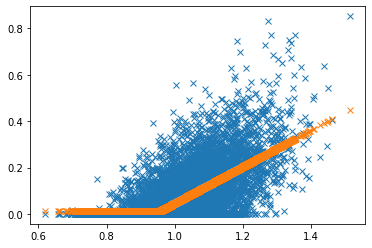

In [102]:
m = 1

plt.plot(x0[:,m].detach().cpu().numpy(),payoff[:,0].detach().cpu().numpy(), 'x')
plt.plot(x0[:,m].detach().cpu().numpy(),output[:,0].detach().cpu().numpy(), 'x')